### CS/ECE/ISyE 524 — Introduction to Optimization — Spring 2018
# Fantasy Baseball Roster Optimizer
## Brian Broeking (broeking@wisc.edu), Kairat Satbekov (satbekov@wisc.edu), Alec Scheele (abscheele@wisc.edu, Victor Calimano (calimano@wisc.edu)

## Table of Contents
1. [Introduction](#intro)
2. [Mathematical Model](#math)
3. [Solutions](#solutions)
    * [Positions](#positions)
    * [Team Array](#team_array)
    * [Opponent Array](#opponent_array)
    * [Constraints](#constraints)
    * [Model](#model)
    * [Stacking](#stacking)
    * [Not Stacking](#not_stacking)
    * [Not Stacking No Overlap](#not_stacking_overlap)
    
4. [Results and Discussions](#results)
5. [Conclusions](#conclusions)

<a id='intro'></a>
# **Introduction**

As fantasy sports grew in popularity over the course of the early 2000's, players became dissatisfied in the season-long format.  Injuries to key players or a player not performing as expected could take your team out of contention early in the season. Fantasy players demanded a more flexible format where they were not locked into players drafted at the beginning of a season, this lead to the birth of daily fantasy sports. 

<img src="ReportResources/contest.png"/>

Draftkings is one of the major providers of daily fantasy sports in the United States. Every day, Draftkings runs online competitions where anywhere from 2 to 50,000+ people compete to build the highest scoring fantasy baseball lineup for that day while staying under a fixed salary constraint of $50,000. The lineup consists of 10 players: two pitchers, a catcher, first, second, and third basemen, a shortstop, and the three outfielders. The best lineups are formed by rostering players who perform well in live Major League Baseball games during that day and, in turn, score points for the lineup. Points are earned based on the type of positive performance a player has for the lineup that day. For example, a hitter will accumulate five points for the lineup if he hits a double and a pitcher will score two points if he records a strikeout.



Draftkings provides many different tournament formats for players to choose from, but for this project, we will focus on the Guaranteed Prize Pool tournaments also known as GPP tournaments. These tournaments have top heavy prizing where players placing in the top 2-5 percent receive a vast majority of the reward compared to the rest of the entrants. 

<img src="ReportResources/prizing.png" />

We sought to discover methods of creating optimal lineups based on projected fantasy points generated by SaberSim, a fantasy baseball statistics organization. Using these projected points as a baseline, we combined these projections with each players’ salary requirements to build lineups like the one pictured below. 


The main way of optimizing any lineup is relying on the projected points of players while staying within the budget. However,  we also want to have a large part of this project focus on the effectiveness of stacking. Stacking is when multiple players of the same team are added into the lineup. We believe that this will be especially useful to our program, because it has been proven to work very well in the past with successful lineups because it has the potential to dramatically increase the maximum points a lineup can score. The idea is that because the prize money is distributed unevenly, with most of it going to the top few percent of lineups there is no incentive to have a moderately successful team, as moderately successful lineups will most likely not even finish “in the money” and the return on investment would be the same as for a team that did very poorly. The idea is that when multiple players from the same team are in the lineup, there is more probability that the players will play off of each other generating a synergy, with more opportunity to get on base and thus more opportunities to score runs, resulting in a higher scoring lineup. 


We will be using a daily lineup and see what the optimal projected lineup is for that day along with the projected lineup score. We will run the program, which is in form of a function, three times. The functions compare a lineup with stacking, a lineup without stacking, and another lineup without stacking with the addition constraint that the players in the lineup have at most 2 players in common with the lineup with stacking. We expect to have better results with stacking.

<img src="ReportResources/entry.png" />

<a id='math'></a>
# **Mathematical Model**




This model is a linear program with binary variables. The goal is to generate multiple lineups in order to optimize the number of hits our lineups get. First, we define the salary cap as the amount of money each player is given to create a lineup for their team. Each player is given a $50,000 cap per team. Call this variable "SalaryCap." 


We also need to have a way to represent if a player is picked in each team. This is done by having binary constraints for our variable. Call this variable "$x_i$." If the $i^{th}$ player is in the lineup, it is represented with a 1 and if not, a 0. We have "n" of these variables to represent the number of players on the roster. The positions they fill on the lineup are two pitchers, a catcher, first, second, and third basemen, short stop, and three outfielders. Represent these positions by "P," "C," "1B," "2B," "3B," "SS," and "OF." There are only 10 positions to be filled, so our first constraint will be the following:

\begin{equation}
\sum_{i=1}^{n}x_i=10
\end{equation}

$\quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad x_i \in \{0,1\}$



We now define "s" to be the vector that determines the salaries of each of the players. By taking the transpose of the row vector, x, and multiply it by the row vector, s. We should get the amount of money we spend for all of the players. We represent this by taking the sum of the products of the $i^{th}$ elements for x and s. This value should be less or equal to the salary cap. This is our first constraint:


\begin{equation} 
 \sum_{i=1}^{n} x_i *s_i\leq SalaryCap    
\end{equation}



We have another constraint where we don't allow a batter to play against a pitcher if the pitcher is being played. The primary goal with this model is to maxamize the scoring for a given lineup. We use this constraint because otherwise, there is a negative correlation between a batter and a pitcher. That is, if the batter scores points for getting a hit or the pitcher scores points for striking a batter out, the other player loses points because they've failed to get a hit or strike a batter out. Let the variable "np" be an array of teams such that they oppose our pitcher. Let $pT_i$ be the team, for which the player batting plays. Therefore, we impose the following constraint:

\begin{equation} 
(x_i +x_j)\leq 1 \quad \forall i \in \{1,2\} \quad \forall j \in \{1,\dots, np[pT_i]\}
\end{equation}         



We now need a way to control how many players can come from a certain team. Baseball is a very volatile sport. It's hard to know whether a certain player will do well or not on a given day regardless of how well they play during the season. However, team synergy is something we may control without needing to spend more money from the salary cap. We also need to consider the fact that we can not have more than 5 hitters per team in the lineup.  Let "NT" denote the number of teams in the MLB. Now define "$T_{m_i}$" as a binary variable where  $T_{m_i}$ is 1 if player i on team m is in the lineup and 0 otherwise. We now create a constraint to be able to have at least 4 players from one team and three players from another team so that we may allow for more synergy, while also respecting the rule from Draftkings saying we can not exceed 5 hitters from any one team. The following constraint represents this. 


\begin{equation}
  \sum_{i=1}^{n} T_{m_i}*x_i \geq 4   \quad  \exists m_i \in \{1, \dots, NT\}
\end{equation}

\begin{equation}
  \sum_{i=1}^{n} T_{m_i}*x_i \geq 3   \quad  \exists m_j \in \{1, \dots, NT\}
\end{equation}

$\quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad  where \quad m_i  \ne  m_j$

\begin{equation}
\sum_{i=1}^{n}\sum_{m=1}^{NT}T_{m_i}*x_i\leq  5  
\end{equation}



$\quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad  \quad \quad \quad \quad \ T_{m_i} \in \{0,1\}$
  
Finally, we have our multiple lineups stacking constaint. This constraint is run after the first lineup for the purpose of making sure the ten teams we are stacking are limited to the amount of overlapping between lineups. Let "LU" be the previously generated lineups. We don't want the number of overlaps between lineups to be more than 7. Call this number "NumOverlap." 


\begin{equation}
\sum_{j=1}^{10} (x[LU_{ij}[1]) \leq NumOverlap \quad \forall i \in \{1, \dots, length(LU)\}
\end{equation}



We want to maximize the projected points for a given daily lineup. Let "$pP_i $" be the projected points a player scores. Thus our model becomes the following:


**Maximize:** 
\begin{equation}
 \sum_{i=1}^{n} x_i*pP_i 
\end{equation}
        
                
**Subject to:**
 
          
  \begin{equation}
  \sum_{i=1}^{n} x_i*s_i\leq SalaryCap 
  \end{equation} 
  \begin{equation}
\sum_{i=1}^{n}x_i=10
\end{equation}

 \begin{equation}
   \sum_{i \in P} x_i= 2,
   \sum_{i \in OF} x_i= 3,
\sum_{i \in SS} x_i= 1,\sum_{i \in 1B} x_i= 1,
 \sum_{i \in 2B} x_i= 1,  \sum_{i \in 3B} x_i= 1
\end{equation}

\begin{equation}
  \sum_{i=1}^{n} T_{m_i}*x_i \geq 4   \quad  \exists m_i \in \{1, \dots, NT\}
\end{equation}

\begin{equation}
  \sum_{i=1}^{n} T_{m_i}*x_i \geq 3   \quad  \exists m_j \in \{1, \dots, NT\}
\end{equation}

$\quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad  where \quad m_i  \ne  m_j$

\begin{equation}
\sum_{i=1}^{n}\sum_{m=1}^{NT}T_{m_i}*x_i\leq  5  
\end{equation}

\begin{equation} 
(x_i +x_j)\leq 1 \quad \forall i \in \{1,2\} \quad \forall j \in \{1,\dots, np[pT_i]\}\}
\end{equation}      


\begin{equation}
\sum_{j=1}^{10} (x[LU_{ij}][1]) \leq NumOverlap \quad \forall i \in \{1, \dots, length(LU)\}
\end{equation}


$\quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad T_{m_i}*x_i \in \{0,1\}$
$x_i \in \{0,1\}$


<a id='solutions'></a>
# 3. Solutions
## Separating input file into usable array

In [280]:
using JuMP, Cbc, NamedArrays

raw = readcsv("output5.6.csv");

# Reading the join csv we generated in Java
# Player Names
names = raw[:,1];
#Player Salaries
salaries = raw[:,2];
# Positions the player plays
position = raw[:, 3];
# Projected points from SaberSim
projectedPoints = raw[:,4];
# Average points from their last 5 outings
averagePoints = raw[:,5];
# Team the player plays for
playerTeam = raw[:,6];
#Team the player is playing against
opponentTeam = raw[:,7];
# Number of unique players
n = length(names)

95

<a id='positions'></a>
## Player position eligibilities
Each player is able to play one or more positions. These arrays represent the players that can play the 
specific position

In [281]:
# Array that holds the index of each player able to play the position that day
# Positional Array
pitchers = Int64[]
catchers = Int64[]
first = Int64[]
second = Int64[]
third = Int64[]
shortStop = Int64[]
fielders = Int64[]

# Adds player to a positional array 
for i in 1:n
 if contains(position[i], "P")
  append!(pitchers, i)
 end
 if contains(position[i], "C")
  append!(catchers, i)
 end
 if contains(position[i], "1B")
  append!(first, i)
 end
 if contains(position[i], "2B")
  append!(second, i)
 end
 if contains(position[i], "3B")
  append!(third, i)
 end
 if contains(position[i], "SS")
  append!(shortStop, i)
 end
 if contains(position[i], "OF")
  append!(fielders, i)
 end
end

<a id='team_array'></a>
## Creates team arrays
Each of these arrays represents the array of players that play for the specified team

In [282]:
# NL East
phillies = Int64[]
atlanta = Int64[]
miami = Int64[]
washington = Int64[]
mets = Int64[]

# AL East
yankees = Int64[]
baltimore = Int64[]
tampa = Int64[]
boston = Int64[]
toronto = Int64[]

# NL Central
milwaukee = Int64[]
pittsburg = Int64[]
reds = Int64[]
cardinals = Int64[]
chicago = Int64[]

# AL Central
whitesox = Int64[]
royals = Int64[]
tigers = Int64[]
cleveland = Int64[]
twins = Int64[]

# AL West
seattle = Int64[]
angels = Int64[]
oakland = Int64[]
houston = Int64[]
texas = Int64[]

# NL West
dodgers = Int64[]
arizona = Int64[]
padres = Int64[]
giants = Int64[]
rockies = Int64[]

0-element Array{Int64,1}

In [283]:
# NL East
for i in 1:n
 if contains(playerTeam[i], " PHI")
  append!(phillies, i)
 end
 if contains(playerTeam[i], " ATL")
  append!(atlanta, i)
 end
 if contains(playerTeam[i], " MIA")
  append!(miami, i)
 end
 if contains(playerTeam[i], " WAS")
  append!(washington, i)
 end
 if contains(playerTeam[i], " NYM")
  append!(mets, i)
 end
    
# AL East
 if contains(playerTeam[i], " NYY")
  append!(yankees, i)
 end
 if contains(playerTeam[i], " BAL")
  append!(baltimore, i)
 end
 if contains(playerTeam[i], " TB")
  append!(tampa, i)
 end
 if contains(playerTeam[i], " BOS")
  append!(boston, i)
 end
 if contains(playerTeam[i], " TOR")
  append!(toronto, i)
 end
    
 # NL Central
 if contains(playerTeam[i], " MIL")
  append!(milwaukee, i)
 end
 if contains(playerTeam[i], " PIT")
  append!(pittsburg, i)
 end
 if contains(playerTeam[i], " CIN")
  append!(reds, i)
 end
 if contains(playerTeam[i], " STL")
  append!(cardinals, i)
 end
 if contains(playerTeam[i], " CHC")
  append!(chicago, i)
 end
    
# AL Central
  if contains(playerTeam[i], " CWS")
  append!(whitesox, i)
 end
 if contains(playerTeam[i], " KCR")
  append!(royals, i)
 end
 if contains(playerTeam[i], " CLE")
  append!(cleveland, i)
 end
 if contains(playerTeam[i], " DET")
  append!(tigers, i)
 end
 if contains(playerTeam[i], " MIN")
  append!(twins, i)
 end

 if contains(playerTeam[i], " SEA")
  append!(seattle, i)
 end
 if contains(playerTeam[i], " LAA")
  append!(angels, i)
 end
 if contains(playerTeam[i], " OAK")
  append!(oakland, i)
 end
 if contains(playerTeam[i], " HOU")
  append!(houston, i)
 end
 if contains(playerTeam[i], " TEX")
  append!(texas, i)
 end
    
 if contains(playerTeam[i], " LAD")
  append!(dodgers, i)
 end
 if contains(playerTeam[i], " ARI")
  append!(arizona, i)
 end
 if contains(playerTeam[i], " SD")
  append!(padres, i)
 end
 if contains(playerTeam[i], " SF")
  append!(giants, i)
 end
 if contains(playerTeam[i], " COL")
  append!(rockies, i)
 end

end

<a id='opponent_array'></a>
## Creates team opponent arrays
Each of these arrays represents the array of players that are playing against the named team that day

In [284]:
# NL East
oppphillies = Int64[]
oppatlanta = Int64[]
oppmiami = Int64[]
oppwashington = Int64[]
oppmets = Int64[]

# AL East
oppyankees = Int64[]
oppbaltimore = Int64[]
opptampa = Int64[]
oppboston = Int64[]
opptoronto = Int64[]

# NL Central
oppmilwaukee = Int64[]
opppittsburg = Int64[]
oppreds = Int64[]
oppcardinals = Int64[]
oppchicago = Int64[]

# AL Central
oppwhitesox = Int64[]
opproyals = Int64[]
opptigers = Int64[]
oppcleveland = Int64[]
opptwins = Int64[]

# AL West
oppseattle = Int64[]
oppangels = Int64[]
oppoakland = Int64[]
opphouston = Int64[]
opptexas = Int64[]

# NL West
oppdodgers = Int64[]
opparizona = Int64[]
opppadres = Int64[]
oppgiants = Int64[]
opprockies = Int64[]

0-element Array{Int64,1}

In [285]:
# NL East
for i in 1:n
 if contains(opponentTeam[i], " PHI")
  append!(oppphillies, i)
 end
 if contains(opponentTeam[i], " ATL")
  append!(oppatlanta, i)
 end
 if contains(opponentTeam[i], " MIA")
  append!(oppmiami, i)
 end
 if contains(opponentTeam[i], " WAS")
  append!(oppwashington, i)
 end
 if contains(opponentTeam[i], " NYM")
  append!(oppmets, i)
 end
    
# AL East
 if contains(opponentTeam[i], " NYY")
  append!(oppyankees, i)
 end
 if contains(opponentTeam[i], " BAL")
  append!(oppbaltimore, i)
 end
 if contains(opponentTeam[i], " TB")
  append!(opptampa, i)
 end
 if contains(opponentTeam[i], " BOS")
  append!(oppboston, i)
 end
 if contains(opponentTeam[i], " TOR")
  append!(opptoronto, i)
 end
    
 # NL Central
 if contains(opponentTeam[i], " MIL")
  append!(oppmilwaukee, i)
 end
 if contains(opponentTeam[i], " PIT")
  append!(opppittsburg, i)
 end
 if contains(opponentTeam[i], " CIN")
  append!(oppreds, i)
 end
 if contains(opponentTeam[i], " STL")
  append!(oppcardinals, i)
 end
 if contains(opponentTeam[i], " CHC")
  append!(oppchicago, i)
 end
    
# AL Central
  if contains(opponentTeam[i], " CWS")
  append!(oppwhitesox, i)
 end
 if contains(opponentTeam[i], " KCR")
  append!(opproyals, i)
 end
 if contains(opponentTeam[i], " CLE")
  append!(oppcleveland, i)
 end
 if contains(opponentTeam[i], " DET")
  append!(opptigers, i)
 end
 if contains(opponentTeam[i], " MIN")
  append!(opptwins, i)
 end

 if contains(opponentTeam[i], " SEA")
  append!(oppseattle, i)
 end
 if contains(opponentTeam[i], " LAA")
  append!(oppangels, i)
 end
 if contains(opponentTeam[i], " OAK")
  append!(oppoakland, i)
 end
 if contains(opponentTeam[i], " HOU")
  append!(opphouston, i)
 end
 if contains(opponentTeam[i], " TEX")
  append!(opptexas, i)
 end
    
 if contains(opponentTeam[i], " LAD")
  append!(oppdodgers, i)
 end
 if contains(opponentTeam[i], " ARI")
  append!(opparizona, i)
 end
 if contains(opponentTeam[i], " SD")
  append!(opppadres, i)
 end
 if contains(opponentTeam[i], " SF")
  append!(oppgiants, i)
 end
 if contains(opponentTeam[i], " COL")
  append!(opprockies, i)
 end
end

<a id='constraints'></a>
## Key constraints for the model

### Salary Constraint (Constraint 1)

All Draftkings lineups will have to have less than 50,000 in player salary.

### Positional Constraint (Constraint 2)

Each Draftkings lineups is required to have 2 pitchers, 1 catcher, 1 first baseman, 1 second baseman, 1 shortstop,
1 third baseman, and 3 outfielders. This results in 10 total players.

### No Batter vs Pitcher Constraint (Constraint 3)

Here we generate a named array that maps team abbreviations to an array of opponents. We use this in the model to check that if a pitcher is being played that no batters are played against him. This is implemented because there is negative correlation between the success of a batter and the success of an opposing pitcher.

For example:
When a batter get a hit off a pitcher, he is awarded 3 points for the single. Pitchers are penalized every time they allow a hit and get -0.60 points. Therefore in the quest to maximize potential scoring for a lineup, it never make sense to play a batter vs. a opposing pitcher.

### Stacking Constraint (Constraint 4)
Stacking lineups has been proven to be the most effective and efficient way to make your Draftkings lineups better. [(Psychology of Stacking)](https://rotogrinders.com/articles/mlb-dfs-psychology-of-stacking-731014) In general, this is because each team has 27 outs per game on the offensive side. The less outs a player makes, the more chances other teammates are given over the course of the game. As a product of the additional at-bats, we are granted more opportunities to generate points. 

### No Duplicate Lineups or Lineups With Too Much Overlap (Constraint 5) 
To achieve success in these Draftkings GPP tournaments, you usually want to have a core of players in most of your lineups. This core gives you a good chance to place highly in the tournament when paired with additional well projected supportive players. This constraint is in place to force our lineups to be individual and overlap no more than 7 players from one lineup to the next.

In [286]:
# total salary
salary_cap = 50000

#number of players at each position
no_pitchers = 2
no_catchers = 1
no_first = 1
no_second = 1
no_third = 1
no_ss = 1
no_of = 3
total_players = 10

# No batter vs pitcher constraint
team_abbv = [" PHI", " ATL", " MIA", " WAS", " NYM",
" NYY", " BAL", " TB", " BOS", " TOR", 
" MIL", " PIT", " CIN", " STL", " CHC", 
" CWS", " KCR", " CLE"," DET"," MIN", 
" SEA", " LAA"," OAK"," HOU"," TEX",
" LAD", " ARI", " SD", " SF", " COL"]

fullnames = ["Philadelphia Phillies", "Atlanta Braves", "Miami Marlins", "Washington Nationals", 
"New York Mets", "New York Yankees", "Baltimore Orioles", "Tampa Bay Rays", "Boston Red Sox", 
"Toronto Blue Jays", "Milwaukee Brewers", "Pittsburgh Pirates", "Cincinnati Reds",
"St. Louis Cardinals", "Chicago Cubs", "Chicago White Sox", "Kansas City Royals", "Cleveland Indians",
"Detroit Tigers", "Minnesota Twins", "Seattle Mariners", "Los Angeles Angels", "Oakland Athletics",
"Houston Astros", "Texas Rangers", "Los Angeles Dodgers", "Arizona Diamondbacks", "San Diego Padres",
"San Francisco Giants", "Colorado Rockies"]

abbs = Dict(zip(team_abbv, fullnames))
println("List of all teams:")
for(j,k) in abbs                        
           println("$j → $k")                  
end 
println()


# In the model, we will look up a pitcher's team. With this information, we will get the index of 
# all of the players who will be excluded because they would be opposing our pitcher
noplaylist = Dict(zip(team_abbv, [oppphillies, oppatlanta, oppmiami, oppwashington, oppmets,
            oppyankees, oppbaltimore, opptampa, oppboston, opptoronto,
            oppmilwaukee, opppittsburg, oppreds, oppcardinals, oppchicago,
            oppwhitesox, opproyals, oppcleveland, opptigers, opptwins,
            oppseattle, oppangels, oppoakland, opphouston, opptexas,
            oppdodgers, opparizona, opppadres, oppgiants, opprockies]))

println("The folowing teams PLAY on chosen day:")
for key = keys(noplaylist)
    if(length(noplaylist[key]) > 0)
        println(key)
    end
end

println("The folowing teams do NOT play on chosen day:")
for key = keys(noplaylist)
    if(length(noplaylist[key]) == 0)
        println(key)
    end
end

println()

println("Indeces of players from playing teams:")
for(j,k) in noplaylist 
        if(length(noplaylist[j]) > 0)
           println("$j → $k")    
    end
end  

List of all teams:
 SD → San Diego Padres
 CWS → Chicago White Sox
 SEA → Seattle Mariners
 CIN → Cincinnati Reds
 BOS → Boston Red Sox
 PHI → Philadelphia Phillies
 DET → Detroit Tigers
 MIL → Milwaukee Brewers
 OAK → Oakland Athletics
 ARI → Arizona Diamondbacks
 MIA → Miami Marlins
 CHC → Chicago Cubs
 TB → Tampa Bay Rays
 TOR → Toronto Blue Jays
 NYM → New York Mets
 BAL → Baltimore Orioles
 STL → St. Louis Cardinals
 LAA → Los Angeles Angels
 TEX → Texas Rangers
 ATL → Atlanta Braves
 SF → San Francisco Giants
 LAD → Los Angeles Dodgers
 MIN → Minnesota Twins
 WAS → Washington Nationals
 HOU → Houston Astros
 PIT → Pittsburgh Pirates
 COL → Colorado Rockies
 KCR → Kansas City Royals
 CLE → Cleveland Indians
 NYY → New York Yankees

The folowing teams PLAY on chosen day:
 SD
 SEA
 CIN
 OAK
 ARI
 MIA
 BAL
 LAA
 LAD
 HOU
The folowing teams do NOT play on chosen day:
 CWS
 BOS
 PHI
 DET
 MIL
 CHC
 TB
 TOR
 NYM
 STL
 TEX
 ATL
 SF
 MIN
 WAS
 PIT
 COL
 KCR
 CLE
 NYY

Indeces of players f

<a id='model'></a>
## Model - generate_lineup() Usage
* noplaylist = Named array of Teams and Int64[] of players opposing that team
* lineups = Previously generated lineups used to eliminate duplicates
* team1 = First team to stack
* team2 = Second team to stack
* lowerbound1 = Minimum number of players from team1 in the lineup
* upperbound1 = Maximum number of players from team1 in the lineup
* lowerbound2 = Minimum number of players from team2 in the lineup
* upperbound2 = Maximum number of players from team2 in the lineup
* overlap = maximum amount of overlap between lineups generated

In [287]:
using DataFrames
function generate_lineup(noplaylist, lineups, team1, team2, lowerbound1, upperbound1,
        lowerbound2, upperbound2, stacking, overlap, frame, count)
    
    m = Model(solver = CbcSolver())
    
    # Maximum amount of salary you can spend on a lineup
    salary_cap = 50000
    
    # Positional requirements for the players
    no_pitchers = 2
    no_catchers = 1
    no_first = 1
    no_second = 1
    no_third = 1
    no_ss = 1
    no_of = 3
    total_players = 10
    
    # Maximum number of players that can overlap with previously generated lineups
    num_overlap = overlap

    # Binary variable for whether a player is chosen or not
    @variable(m, x[1:n], Bin)

    # Constraint 1
    # total salary must be under 50K
    @constraint(m, sum(x .* salaries) <= salary_cap)

    # Constraint 2
    # Constraints must fit line up, eg. two pitchers, one catcher, one 1B etc 
    @constraint(m, sum(x[i] for i in pitchers) == no_pitchers)
    @constraint(m, sum(x[i] for i in catchers) == no_catchers)
    @constraint(m, sum(x[i] for i in first) == no_first)
    @constraint(m, sum(x[i] for i in second) == no_second)
    @constraint(m, sum(x[i] for i in third) == no_third)
    @constraint(m, sum(x[i] for i in shortStop) == no_ss)
    @constraint(m, sum(x[i] for i in fielders) == no_of)
    @constraint(m, sum(x[i] for i in 1:n) == total_players)

    # Constraint 3
    # No batter vs pitcher constraint
    for i = 1:length(pitchers)
        for j in noplaylist[playerTeam[i]]
          @constraint(m, (x[i] + x[j]) <= 1)
        end
    end

    # Constraint 4
    # In this example we want between 4 and 5 players from Team A
    # and between 3 and 4 players from Team B
    if(stacking)
      @constraint(m, lowerbound1 <= sum(x[i] for i in team1) <= upperbound1)
      @constraint(m, lowerbound2 <= sum(x[i] for i in team2) <= upperbound2)
    end

    # Constraint 5
    # To maximize the effectiveness of the large scale lineup generation, we limit the
    # amount of overlap among the lineups previously generated
    @constraint(m, constr[i=1:size(lineups)[1]], sum( x[(lineups[i][j])] for j=1:10 ) <= num_overlap)

    # Objective to maximize projected points
    @objective(m, Max, sum(x .* projectedPoints))

    solve(m)

    x = getvalue(x)

    # Prints the lineups
    lineup = Int64[]
    for i in 1:length(x)
     if x[i] == 1
      push!(frame, [count names[i] position[i] salaries[i] 0])
      append!(lineup, i)
     end
    end
    
    # Push lineup generated into the list of previously generated lineup
    # This allows us to check in future iterations to make sure we don't have 
    # too much overlap between lineups
    push!(lineups, lineup)
    
    push!(frame, [0, "", "", 0, getobjectivevalue(m)])
end

generate_lineup (generic function with 4 methods)

<a id='stacking'></a>
## Generates 10 lineups (Stacking)

In [288]:
using DataFrames
# Infeasible lineup added to lineups array to allow for consistant overlap checking
lineups = Array{Int64}[]
first_lineup = Int64[]
push!(first_lineup, 1), push!(first_lineup, 2)
push!(first_lineup, 3), push!(first_lineup, 4), push!(first_lineup, 5), push!(first_lineup, 6)
push!(first_lineup, 7), push!(first_lineup, 8), push!(first_lineup, 9), push!(first_lineup, 10)
push!(lineups, first_lineup)

summary = DataFrame(Lineup = Int64[], PlayerName = String[], Position = String[], Salary = Int64[], ProjectedPoints = Float64[])
# Generate Lineups
for i in 1:10
    generate_lineup(noplaylist, lineups, angels, miami, 4, 5, 3, 4, true, 7, summary, i)
end
showall(summary)

110×5 DataFrames.DataFrame
│ Row │ Lineup │ PlayerName             │ Position │ Salary │ ProjectedPoints │
├─────┼────────┼────────────────────────┼──────────┼────────┼─────────────────┤
│ 1   │ 1      │ "Justin Verlander"     │ " P"     │ 13200  │ 0.0             │
│ 2   │ 1      │ "Andrew Triggs"        │ " P"     │ 7900   │ 0.0             │
│ 3   │ 1      │ "Mike Trout"           │ " OF"    │ 5900   │ 0.0             │
│ 4   │ 1      │ "J.T. Realmuto"        │ " C"     │ 4200   │ 0.0             │
│ 5   │ 1      │ "Andrelton Simmons"    │ " SS"    │ 3900   │ 0.0             │
│ 6   │ 1      │ "Justin Bour"          │ " 1B"    │ 3400   │ 0.0             │
│ 7   │ 1      │ "Ian Kinsler"          │ " 2B"    │ 3300   │ 0.0             │
│ 8   │ 1      │ "Lewis Brinson"        │ " OF"    │ 3200   │ 0.0             │
│ 9   │ 1      │ "Chris Young"          │ " OF"    │ 2500   │ 0.0             │
│ 10  │ 1      │ "Kyle Farmer"          │ " 3B"    │ 2400   │ 0.0             │
│ 11  │ 0    

│ 103 │ 10     │ "Justin Upton"         │ " OF"    │ 4300   │ 0.0             │
│ 104 │ 10     │ "Andrelton Simmons"    │ " SS"    │ 3900   │ 0.0             │
│ 105 │ 10     │ "Justin Bour"          │ " 1B"    │ 3400   │ 0.0             │
│ 106 │ 10     │ "Ian Kinsler"          │ " 2B"    │ 3300   │ 0.0             │
│ 107 │ 10     │ "Lewis Brinson"        │ " OF"    │ 3200   │ 0.0             │
│ 108 │ 10     │ "Cameron Maybin"       │ " OF"    │ 3100   │ 0.0             │
│ 109 │ 10     │ "Rene Rivera"          │ " C"     │ 2700   │ 0.0             │
│ 110 │ 0      │ ""                     │ ""       │ 0      │ 136.31          │

<a id='not_stacking'></a>
## Generates 10 lineups (Not Stacking)

In [289]:
using DataFrames
# Infeasible lineup added to lineups array to allow for consistant overlap checking
lineups_notstacking = Array{Int64}[]
first_lineup = Int64[]
push!(first_lineup, 1), push!(first_lineup, 2)
push!(first_lineup, 3), push!(first_lineup, 4), push!(first_lineup, 5), push!(first_lineup, 6)
push!(first_lineup, 7), push!(first_lineup, 8), push!(first_lineup, 9), push!(first_lineup, 10)
push!(lineups_notstacking, first_lineup)

summary = DataFrame(Lineup = Int64[], PlayerName = String[], Position = String[], Salary = Int64[], ProjectedPoints = Float64[])

for i in 1:10
    # In this example the angels, miami, 4, 5, 3, 4 variable don't go into the 
    # generation of the lineups because stacking is set to false
    generate_lineup(noplaylist, lineups_notstacking, angels, miami, 4, 5, 3, 4, false, 7, summary, i)
end
showall(summary)

110×5 DataFrames.DataFrame
│ Row │ Lineup │ PlayerName         │ Position │ Salary │ ProjectedPoints │
├─────┼────────┼────────────────────┼──────────┼────────┼─────────────────┤
│ 1   │ 1      │ "Justin Verlander" │ " P"     │ 13200  │ 0.0             │
│ 2   │ 1      │ "Andrew Triggs"    │ " P"     │ 7900   │ 0.0             │
│ 3   │ 1      │ "Joey Votto"       │ " 1B"    │ 4800   │ 0.0             │
│ 4   │ 1      │ "Scott Schebler"   │ " OF"    │ 4400   │ 0.0             │
│ 5   │ 1      │ "J.T. Realmuto"    │ " C"     │ 4200   │ 0.0             │
│ 6   │ 1      │ "Scooter Gennett"  │ " 2B"    │ 3700   │ 0.0             │
│ 7   │ 1      │ "Matt Kemp"        │ " OF"    │ 3400   │ 0.0             │
│ 8   │ 1      │ "Lewis Brinson"    │ " OF"    │ 3200   │ 0.0             │
│ 9   │ 1      │ "Freddy Galvis"    │ " SS"    │ 2800   │ 0.0             │
│ 10  │ 1      │ "Kyle Farmer"      │ " 3B"    │ 2400   │ 0.0             │
│ 11  │ 0      │ ""                 │ ""       │ 0      │ 148

<a id='not_stacking_overlap'></a>
## Generates 10 lineups (Not Stacking, No Core Due To Overlap Constraint = 2)

In [290]:
using DataFrames
# Infeasible lineup added to lineups array to allow for consistant overlap checking
lineups_notstacking_minoverlap = Array{Int64}[]
first_lineup = Int64[]
push!(first_lineup, 1), push!(first_lineup, 2)
push!(first_lineup, 3), push!(first_lineup, 4), push!(first_lineup, 5), push!(first_lineup, 6)
push!(first_lineup, 7), push!(first_lineup, 8), push!(first_lineup, 9), push!(first_lineup, 10)
push!(lineups_notstacking_minoverlap, first_lineup)

summary = DataFrame(Lineup = Int64[], PlayerName = String[], Position = String[], Salary = Int64[], ProjectedPoints = Float64[])
for i in 1:10
    # In this example the angels, miami, 4, 5, 3, 4 variable don't go into the 
    # generation of the lineups
    generate_lineup(noplaylist, lineups_notstacking_minoverlap, angels, miami, 4, 5, 3, 4, false, 2, summary, i)
end
showall(summary)

110×5 DataFrames.DataFrame
│ Row │ Lineup │ PlayerName             │ Position │ Salary │ ProjectedPoints │
├─────┼────────┼────────────────────────┼──────────┼────────┼─────────────────┤
│ 1   │ 1      │ "Justin Verlander"     │ " P"     │ 13200  │ 0.0             │
│ 2   │ 1      │ "Andrew Triggs"        │ " P"     │ 7900   │ 0.0             │
│ 3   │ 1      │ "Joey Votto"           │ " 1B"    │ 4800   │ 0.0             │
│ 4   │ 1      │ "Scott Schebler"       │ " OF"    │ 4400   │ 0.0             │
│ 5   │ 1      │ "J.T. Realmuto"        │ " C"     │ 4200   │ 0.0             │
│ 6   │ 1      │ "Scooter Gennett"      │ " 2B"    │ 3700   │ 0.0             │
│ 7   │ 1      │ "Matt Kemp"            │ " OF"    │ 3400   │ 0.0             │
│ 8   │ 1      │ "Lewis Brinson"        │ " OF"    │ 3200   │ 0.0             │
│ 9   │ 1      │ "Freddy Galvis"        │ " SS"    │ 2800   │ 0.0             │
│ 10  │ 1      │ "Kyle Farmer"          │ " 3B"    │ 2400   │ 0.0             │
│ 11  │ 0    

<a id='results'></a>
# 4. Results and discussions

We used our model to generate 30 different Draftkings lineups for a contest involving five games played on May 6th, 2018. We used three different strategies, with ten lineups generated with each strategy.  In this contest, lineups that scored over 118.8 received some portion of the prize payout with majority of the prize money being paid to teams that scored in the top few percent.  Six of ten lineups, both from those created based around a Stacking strategy and a Not-Stacking strategy, placed “In the money”, while only two of the Not-Stacking Limited Lineup lineups placed in the money.  This particular contest highlights the volatility of fantasy baseball in that both the Not-Stacking and the Not-Stacking Limited Lineup strategies faired better than one would have expected. Conventional fantasy baseball wisdom suggests that the Not-Stacking Limited Overlap lineups would have done outright poorly. Additionally, the Not-Stacking based strategy would have been an improvement over the Not-Stacking Limited Overlap, while still fairing worse than the Stacked lineups.

 

### Stacking

Stacking is the bread and butter of daily fantasy sports.  The positive correlation between players on the same team leads to stacking being one of the most prevalent strategies used by fantasy sports players to generate competitive lineups.  One of the results of using a stacking strategy is that even while generating many distinct lineups, all or most lineups will maintain an artificial core of players that are projected to play well.  Distinct lineups will maintain this core because of the lineup requirements of representing three different teams in a lineup and the relatively limited number of players that are both affordable and projected to score well.  A core of players that perform well creates a baseline for all lineups created for a given contest, which is then supplemented by other highly projected players to create a complete lineup.  This strategy creates lineups with slight variations that maximize the potential return by giving you the greatest chance of placing near the top of the tournament. The value of stacking players on the same team comes from a player in your lineup getting on base. This makes it so that there are more chances that another player in your lineup who is on that same team will drive that first player in for a run generating addition points for both players in your lineup.  The volatility of baseball creates scenarios where projections are best used as a general guide, and generating lineups simply with the best projected players generally does not work out particularly well as explored in the next section.  In this particular contest while the Stacking based strategy put six of ten lineups “into the money” the Not-Stacking based strategy actually had a higher point total for its highest scoring lineup.

 

### Not-Stacking

The Not-Stacking strategy carries over the requirements that no more than seven players overlap between lineups and also attempts to maximize the projected points, but instead of taking advantage of the positive correlation between players on the same team we simply take the best possible players from all teams playing in the games in the contest, essentially we are simply trying to maximize the projected points while staying within the salary constraint and other lineup requirements.  Similarly to the stacking strategy the Not-Stacking strategy will also develop a core base of players that are projected to score well and that meet the requirements of representing three different teams.  The largest disadvantage to not stacking is that you miss out on the absolute upside of having a team with stacked players.  While Not-Stacking has a higher point floor this bares no actual advantage because only the top twenty percent or so of lineups receive the prize so there is no difference in profitability between a lineup that only makes it into the top thirty percent and a lineup with a score of zero.  While in the single contest that we entered the Not-Stacked lineups did score better than the Stacked lineups over a larger sample size this generally will not be the case.

 

### Not-Stacking Limited Lineup Overlap

The Not-Stacking Limited Lineup Overlap is the worst lineup creation strategy and is meant to mimic something a novice user might attempt. Projections are pretty widely available so novice players generating lineups by hand have the ability to incorporate them, but they most likely wouldn't create a core of players. Their player pool would be too large and given the volatility of baseball the lack of a core would give the player almost no chance of ever winning a top prize or even placing within the money. That being said given the volatility of baseball, it is entirely possible for a lineup made using this strategy to succeed but it should be viewed as a poor investment.

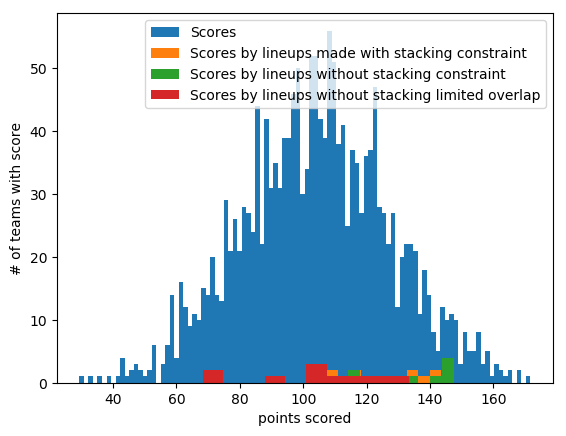

In [291]:
using PyPlot

raw = readcsv("DKresults.csv")
n = length(raw)

# Seperate each lineups score from the greater document
scores = raw[1,16:13:n]
# Scores made by lineup with stacking constraint
stackingScores = [142.45, 117.3, 136.3, 115.45, 143.45, 134.45, 109.3, 121.8, 135.8, 107.45]
# Scores made by line up without stacking constraint
unstackedScores = [133.45, 114.45, 147.45, 145.45, 146.45, 140.45, 116.3, 110.45, 146.45, 118.45]
# Scores made by line ups without stacking or core
no_stackCore = [133.45, 122.3, 104.45, 101.8, 112.3, 105.45, 89.8, 70.7, 115.45, 68.3]

#Graph
plt[:hist](scores,100, label="Scores")
plt[:hist](stackingScores,10, label="Scores by lineups made with stacking constraint")
plt[:hist](unstackedScores,10, label="Scores by lineups without stacking constraint")
plt[:hist](no_stackCore, 10, label="Scores by lineups without stacking limited overlap")
xlabel("points scored")
ylabel("# of teams with score")
legend(loc = "best", fontsize=10); ## legend position

<a id='conclusions'></a>
# 5. Conclusions
One of the most exciting improvements we can make is developing an additional model and data pipeline to improve the selection of teams to stack. Currently, we are simply using basic Vegas lines and personal preference to select the teams that will be stacked. There are several datasets we could explore to improve our selection process.

### Draftkings Past Contest Dataset
After each Draftkings competition, a tournament report is generated that players are allowed to download in comma separated value format. These reports include the names of users competing, their lineup, their score and rank in the competition. Given the amount of data that is generated, we can create lineups for past events based on these reports. After we generate the lineups, we can test them against the tournament results to determine if we are generating viable lineups. Additionally, a minority of players who participate in Draftkings take home the majority of the winnings. We can use the contest data to determine the successful players. Once we know those who succeed, we can deconstruct their lineup building decisions and implement their strategies as our own.

### Donbest.com Dataset
Donbest.com collects Vegas gambling data from various online sportsbooks for each game played during the Major League Baseball season. The moneyline odds and over/under totals are the two main data sources we will look to use in making our roster decisions.
From the moneyline, we can calculate the implied probability of a team winning a game. The over/under totals tell us the amount of runs that the sportsbooks expect to be scored in the game. Using these two data points in conjunction, we can generate implied run totals. Implied run totals tell us the number of runs an individual team is expected to score. With this data we can build models that will help inform our decision to include or exclude different teams from the lineup building process. 

### Statcast Dataset
In partnership with Amazon Web Services, every Major League Baseball stadium has been equipped with radar technology that tracks every play on the field. These tools collect data such as exit velocity off the bat and the spin rate of a pitchers fastball. Statistics like these have been revolutionizing the way baseball is played and discovering the predictive value of some of these statistics and incorporating them into a model seems like the next logical way to develop a competitive advantage over the Draftkings community. 
One example of as Statcast powered statistic is expected weighted on base percentage [(xwOBA)](https://www.fangraphs.com/library/offense/woba/). xwOBA predicts a batters expected offensive contribution based on their batted balls recorded by the Statcast system. Exploring xwOBA could allow us to discover players who are over-performing or underperforming their hitting abilities. Once we have identified these players we can incentivize our model to include them as high valued additions to a lineup.